In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn

from typing import Tuple
from typing import List
from copy import deepcopy, copy

from torch import nn
from torch.optim import SGD
from torch.nn.functional import cross_entropy

import sklearn
import sklearn.metrics 
#from sklearn.metrics import recall_score
#from sklearn.metrics import precision_score

# Read data and create data loader:

In [2]:
train_set = pd.read_csv('train_set_V.csv')[:500000]
valid_set = pd.read_csv('val_set_V.csv')[:50000]
test_set = pd.read_csv('test_set_V.csv')[:50000]

valid_set.head()

,AGE,HAS_AE,HAS_AW,HAS_IP,LOGICAL_FACTOR_1,LOGICAL_FACTOR_2,SEX_K,SEX_M,SEX_N,NATIONALITY_0,...,PKD_GROUP_90,PKD_GROUP_91,PKD_GROUP_93,PKD_GROUP_95,PKD_GROUP_96,PKD_GROUP_97,PKD_GROUP_98,PKD_GROUP_99,PKD_GROUP_na,TARGET
0,-0.831952,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
1,-0.611007,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,-1.077384,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,-0.634381,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.059898,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
y_train = np.array(train_set['TARGET'])
x_train = np.array(train_set.drop(['TARGET'], axis=1))

y_val = np.array(valid_set['TARGET'])
x_val = np.array(valid_set.drop(['TARGET'], axis=1))

y_test = np.array(test_set['TARGET'])
x_test = np.array(test_set.drop(['TARGET'], axis=1))

In [4]:
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()

x_val =  torch.from_numpy(x_val).float()
y_val =  torch.from_numpy(y_val).long()

x_test =  torch.from_numpy(x_test).float()
y_test =  torch.from_numpy(y_test).long()

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)


torch.Size([500000, 202]) torch.Size([500000])
torch.Size([50000, 202]) torch.Size([50000])
torch.Size([50000, 202]) torch.Size([50000])


In [5]:
input_dim = x_train.shape[1]
output_dim = 2 ## number of classes

# Neural network model:

In [6]:
class TheModelClass(nn.Module):
    def __init__(self, input_dim, hidden_dim1,hidden_dim2, output_dim):
        super(TheModelClass, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):   ## softmax, tanh, relu, sigmoid
        x = torch.tanh(self.fc1(x))   
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
def train_my_network(x_train, y_train, x_test, y_test, epoch, lr, momentum, hidden_dim1, hidden_dim2):
    
    
    # initialize the model, loss function and optimizer
    model: TheModelClass = TheModelClass(input_dim, 40,40,output_dim)
    optimizer: torch.optim.Optimizer = SGD(model.parameters(), lr=lr, momentum=momentum)
    criterion = nn.CrossEntropyLoss()
    
    ## for visual 
    loss_tab = []
    test_accuracy_tab = []
    train_accuracy_tab = []
    
    ## training loop:
    for e in range(epoch):   
        ## shuffle training data
        ordering = np.arange(x_train.shape[0])
        np.random.shuffle(ordering)
        x_train = x_train[ordering]
        y_train = y_train[ordering]
        
        optimizer.zero_grad()
        output: torch.Tensor = model(x_train)  
        loss: torch.Tensor = criterion(output, y_train)            
        loss.backward()
        optimizer.step()
        loss_tab.append(loss.item())        
        
        with torch.no_grad():
            output: torch.Tensor = model(x_train)  
            pred_labels = torch.argmax(output, 1)
            correct = ( (pred_labels - y_train) ==0).sum()
            train_accuracy_tab.append( float(correct) / len(y_train))
            #print(f"epoch {e} \tTrain accuracy: ", train_accuracy_tab[-1])   
            
            output: torch.Tensor = model(x_test)  
            pred_labels = torch.argmax(output, 1)
            correct = ( (pred_labels - y_test) ==0).sum()
            test_accuracy_tab.append( float(correct) / len(y_test))
            #print(f"epoch {e} \tTest accuracy: ", test_accuracy_tab[-1])  
            y_true = np.array(y_test) 
            y_pred = pred_labels
            recall_score = sklearn.metrics.recall_score( y_true, y_pred) 
            precision_score = sklearn.metrics.precision_score(y_true, y_pred)
          
    ## Vizualisation
    fig, axs = plt.subplots(1, 2, figsize = (16, 5))
    axs[0].plot(loss_tab, color = 'indigo')
    axs[1].plot(train_accuracy_tab, color='pink')
    axs[1].plot(test_accuracy_tab, color='indigo')
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].grid(True)
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].grid(True)
    plt.show()
    

    print("accuracy on training set: {:}\t testing set: {:}, precision = {:}, recall={:}".format(train_accuracy_tab[-1], test_accuracy_tab[-1], precision_score, recall_score ))
    return model

# Grid search:

epoch: int = 300
hidden_dim1 = 50#100
hidden_dim2 = 50#100

lr_tab = [0.04, 0.06, 0.08]
momentum_tab = [0.8, 0.9]

for lr in lr_tab:
    for momentum in momentum_tab:
        train_my_network(x_train, y_train, x_val, y_val, epoch, lr, momentum, hidden_dim1, hidden_dim2)
        print("lr = ", lr, "momentum = ", momentum )

epoch: int = 300
hidden_dim1 = 100
hidden_dim2 = 100

lr_tab = [0.04, 0.06, 0.08]
momentum_tab = [0.9, 0.8]

for lr in lr_tab:
    for momentum in momentum_tab:
        train_my_network(x_train, y_train, x_val, y_val, epoch, lr, momentum, hidden_dim1, hidden_dim2)
        print("lr = ", lr, "momentum = ", momentum )

epoch: int = 400
hidden_dim1 = 100
hidden_dim2 = 100

lr_tab = [0.06, 0.08]
momentum_tab = [0.9, 1.0]

for lr in lr_tab:
    for momentum in momentum_tab:
        train_my_network(x_train, y_train, x_val, y_val, epoch, lr, momentum, hidden_dim1, hidden_dim2)
        print("lr = ", lr, "momentum = ", momentum )

# Best models - choosen parameters 

/home/neofelia/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


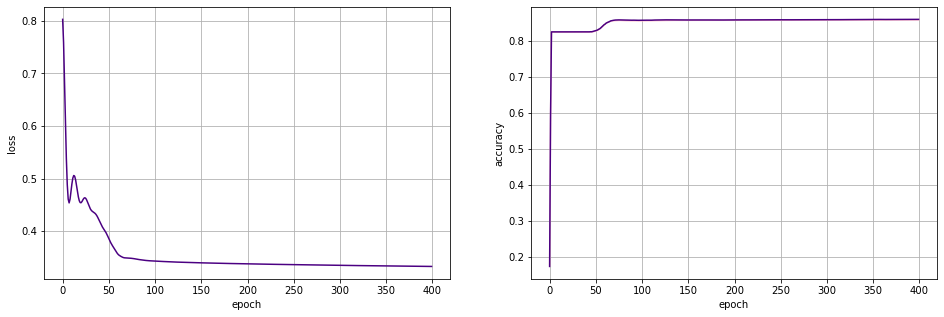

accuracy on training set: 0.85939	 testing set: 0.86086, precision = 0.704995287464656, recall=0.3440266758652409


In [8]:
epoch: int = 400
lr =  0.06
momentum = 0.9
hidden_dim1 = 100
hidden_dim2 = 100

model = train_my_network(x_train, y_train, x_test, y_test, epoch, lr, momentum, hidden_dim1, hidden_dim2)

## Save model

In [9]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    
torch.save(model.state_dict(), "neural_network_model.h4")

Model's state_dict:
fc1.weight 	 torch.Size([40, 202])
fc1.bias 	 torch.Size([40])
fc2.weight 	 torch.Size([40, 40])
fc2.bias 	 torch.Size([40])
fc3.weight 	 torch.Size([2, 40])
fc3.bias 	 torch.Size([2])


## Load model

In [10]:
model = TheModelClass(input_dim, 40,40,output_dim)
model.load_state_dict(torch.load("neural_network_model.h4"))

<All keys matched successfully>

# Final evaluation:

In [11]:
with torch.no_grad():
    output: torch.Tensor = model(x_train)  
    pred_labels = torch.argmax(output, 1)
    correct = ( (pred_labels - y_train) ==0).sum()
    accuracy = ( float(correct) / len(y_train))
    print("Test accuracy: {:.2f} %".format(accuracy * 100))       
    
    output: torch.Tensor = model(x_val)  
    pred_labels = torch.argmax(output, 1)
    correct = ( (pred_labels - y_val) ==0).sum()
    accuracy = ( float(correct) / len(y_val))
    print("Test accuracy: {:.2f} %".format(accuracy * 100))       
    
    output: torch.Tensor = model(x_test)  
    pred_labels = torch.argmax(output, 1)
    correct = ( (pred_labels - y_test) ==0).sum()
    accuracy = ( float(correct) / len(y_test))
    print("Test accuracy: {:.2f} %".format(accuracy * 100))   
    
    
    y_true = np.array(y_test) 
    y_pred = pred_labels
    recall_score = sklearn.metrics.recall_score( y_true, y_pred) 
    precision_score = sklearn.metrics.precision_score(y_true, y_pred)
    
    print("Presicion on testing set:", precision_score)
    print("Recall on testing set:", recall_score)

Test accuracy: 85.94 %
Test accuracy: 85.85 %
Test accuracy: 86.09 %
Presicion on testing set: 0.704995287464656
Recall on testing set: 0.3440266758652409
